In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [24]:
df = pd.read_table('/home/mallesh/HPE-QoE-Labels/bitbucket/video-qoe-labeling/data.txt', delim_whitespace=True, dtype = {'BitRate': np.float64, 'FreezeRatio': np.float64, 'Quality': np.int32})

In [25]:
df['BitRate'] = df['BitRate']/100

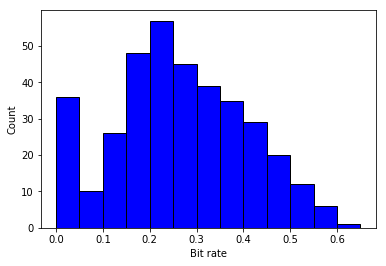

In [26]:
plt.hist(df['BitRate'], bins = [0.05*x for x in range(14)],facecolor='blue', edgecolor = 'black')
plt.xlabel('Bit rate')
plt.ylabel('Count')
plt.show()

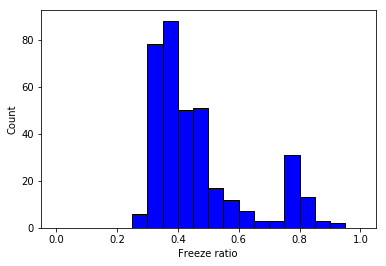

In [27]:
plt.hist(df['FreezeRatio'], bins = [0.05*x for x in range(21)],facecolor='blue', edgecolor = 'black')
plt.xlabel('Freeze ratio')
plt.ylabel('Count')
plt.show()

In [28]:
# get (X, y) and set fold
X, y = np.array(df[['BitRate', 'FreezeRatio']]), np.array(df['Quality'])
accuracies = {}
confusion = {}
fold = 5

In [29]:
# function for performing k-fold cross validation 
def k_Fold_CV(classifier, n):
    accuracies = []
    confusion = []
    kf = KFold(n_splits = n)
    for train, test in kf.split(X):
        pred = classifier.fit(X[train], y[train]).predict(X[test])
        accuracies.append(classifier.score(X[test], y[test]))
        confusion.append(confusion_matrix(y[test], pred))
    return (accuracies, confusion)

In [30]:
# random forest
params = {'n_estimators': range(1, 21), 'criterion': ('gini', 'entropy')}
clf = GridSearchCV(RandomForestClassifier(random_state = 1), params)
clf.fit(X, y)
print("Best estimator: ", clf.best_estimator_)
print("Accuracies: {}".format(clf.best_score_))

('Best estimator: ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=13, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False))
Accuracies: 0.774725274725


In [31]:
# Grid search found the best estimator to be n_estimators = 13 using gini index 
classifier = RandomForestClassifier(n_estimators = 13, criterion = 'gini', random_state = 1)
accuracies['random_forest'], confusion['random_forest'] = k_Fold_CV(classifier, fold)

In [32]:
# k nearest neighbors
params = {'n_neighbors':range(1, 11)}
clf = GridSearchCV(KNeighborsClassifier(), params)
clf.fit(X, y)
print("Best estimator: ", clf.best_estimator_)
print("Accuracies: {}".format(clf.best_score_))

('Best estimator: ', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform'))
Accuracies: 0.813186813187


In [33]:
# best estimator is n_neighbors = 9 found by grid search
accuracies['nearest_neighbor'], confusion['nearest_neighbor'] = k_Fold_CV(KNeighborsClassifier(n_neighbors = 9), fold)

In [34]:
# Naive Bayes classifier
accuracies['naive_bayers'], confusion['naive_bayers'] = k_Fold_CV(GaussianNB(), fold)

In [35]:
# SVM classfier
params = {'kernel':('poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10]}
clf = GridSearchCV(SVC(random_state = 12345), params)
clf.fit(X, y)
print(clf.best_estimator_, clf.best_score_)

(SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=12345, shrinking=True,
  tol=0.001, verbose=False), 0.76373626373626369)


In [36]:
# best estimator is C = 10, kernel = 'rbf' by grid search
accuracies['svm'], confusion['svm'] = k_Fold_CV(SVC(C = 10, kernel = 'rbf'), fold)

In [37]:
for k, v in accuracies.items():
    print(k)
    print("{}_fold accuracies: ".format(fold), np.around(v, decimals = 3))
    print("Average accuracy: {0:0.3f}".format(np.mean(v)))
    print("#################################")

naive_bayers
('5_fold accuracies: ', array([ 0.877,  0.753,  0.849,  0.808,  0.736]))
Average accuracy: 0.805
#################################
nearest_neighbor
('5_fold accuracies: ', array([ 0.836,  0.849,  0.918,  0.753,  0.736]))
Average accuracy: 0.818
#################################
random_forest
('5_fold accuracies: ', array([ 0.808,  0.849,  0.918,  0.74 ,  0.722]))
Average accuracy: 0.807
#################################
svm
('5_fold accuracies: ', array([ 0.863,  0.795,  0.877,  0.767,  0.736]))
Average accuracy: 0.807
#################################


In [38]:
# function for computing the ROC curves in k-fold CV

def k_Fold_roc(classifier, n, labels):
    y_bin = label_binarize(y, classes = labels)
    aucs = []
    kf = KFold(n_splits = n)
    for train, test in kf.split(X):
        y_score = ovr(classifier).fit(X[train], y_bin[train]).predict_proba(X[test])
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(len(labels)):
            fpr[i], tpr[i], _ = roc_curve(y_bin[test][:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        aucs.append(roc_auc)
    return aucs 

In [39]:
fold = 10
labels = [0, 1, 2]
aucs = {}
classifiers = {'random_forest': RandomForestClassifier(n_estimators = 13, random_state = 1), 
               'nearest_neighbor': KNeighborsClassifier(n_neighbors = 9),
               'naive_bayers': GaussianNB(),
               'svm': SVC(C = 10, kernel = 'rbf', probability = True)}
for k, v in classifiers.items():
    aucs[k] = k_Fold_roc(v, fold, labels)

In [40]:
for k, v in aucs.items():
    print(k)
    print("{}_fold AUCs: ".format(fold))
    for x in v:
        print(x)
    print("#################################")

naive_bayers
10_fold AUCs: 
{0: 1.0, 1: 0.4391025641025641, 2: 0.93939393939393934}
{0: 0.98518518518518527, 1: 0.41346153846153844, 2: 0.97826086956521741}
{0: 1.0, 1: 0.51333333333333331, 2: 0.97756410256410253}
{0: 0.99300699300699302, 1: 0.47826086956521741, 2: 0.97666666666666668}
{0: 0.98996655518394649, 1: 0.53511705685618738, 2: 0.99230769230769234}
{0: 1.0, 1: 0.51666666666666672, 2: 0.98730158730158735}
{0: 1.0, 1: 0.43209876543209869, 2: 0.94805194805194803}
{0: 1.0, 1: 0.61269841269841274, 2: 0.89230769230769236}
{0: 1.0, 1: 0.36728395061728397, 2: 0.81168831168831168}
{0: 1.0, 1: 0.6205357142857143, 2: 0.87616099071207432}
#################################
nearest_neighbor
10_fold AUCs: 
{0: 1.0, 1: 0.87980769230769229, 2: 0.93939393939393934}
{0: 0.97592592592592586, 1: 0.90224358974358976, 2: 0.96894409937888204}
{0: 0.9966666666666667, 1: 0.90833333333333333, 2: 0.95192307692307687}
{0: 0.99125874125874125, 1: 0.91304347826086962, 2: 0.97166666666666668}
{0: 0.958193979